# CNN : Deep Learning for Computer Vision

L’objectif de ce notebook est de concevoir des réseaux de neurones convolutionnels (CNN ou ConvNets) et de les appliquer à des problématiques telles que la reconnaissance faciale.

Les CNN sont spécialement conçus pour le traitement des images : ils reposent sur l’hypothèse que les données d’entrée sont de nature visuelle, ce qui permet d’intégrer directement dans l’architecture du réseau certaines propriétés spécifiques aux images. Un CNN se présente ainsi comme une succession de couches transformant un volume d’entrée (image) en un volume de sortie, par exemple sous la forme de scores de classification.

Dans un premier temps, nous construirons un CNN que nous appliquerons à la base de données CIFAR-10, en utilisant une architecture composée de couches convolutionnelles (CONV), de fonctions d’activation ReLU, de couches de pooling, puis de couches entièrement connectées (FC).

### I. CIFAR-10

Etude de cas : CIFAR-10, 60 000 images, 10 classes

Etapes : Import, Préparation, Modèle, Entraînement, Evaluation.

In [ ]:
# !pip install torch torchvision matplotlib tqdm seaborn scikit-learn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support


  Using cached torch-2.10.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (31 kB)
  Using cached torchvision-0.25.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (5.4 kB)
  Using cached filelock-3.20.3-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached fsspec-2026.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached cuda_bindings-12.9.4-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (2.6 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_cupti_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cudnn_cu12-9.10.2.21-py3-none-manylinux_2_27_x86_64.whl.metadata (1.8 k

In [ ]:
# Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 0.001
print(f"Utilisation de : {DEVICE}")


Utilisation de : cpu


1. Chargement et préparation des données

Dans un premier temps, nous allons charger le dataset CIFAR-10 à partir de torchvision, ainsi que préparer les images afin de les rendre exploitable par PyTorch. On applique dans ce cadre des augmentations afin d'augmenter la robustesse du modèle.

In [ ]:
# Transformations

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(), # ajoute de la variabilité au modèle
    transforms.RandomCrop(32, padding=4), # décentre les objets, rend le modèle plus robuste
    transforms.ToTensor(), #tenseurs PyTorch
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #normalisation des images
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train = True, download=True,
    transform = transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True,
    transform=transform_test
)

# Création de l'ensemble de validation de 10% du train
train_size = int(0.9*len(train_dataset))
val_size= len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle = False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = False, num_workers=2)

# Classes CIFAR-10
classes = ('avion', 'auto', 'oiseau', 'chat', 'cerf', 'chien', 'grenouille', 'cheval', 'bateau', 'camion')

# Informations sur le dataset
print(f"Dataset d'entraînement : {len(train_dataset)} images")
print(f"Dataset de validation : {len(val_dataset)} images")
print(f"Dataset de test : {len(test_dataset)} images")
print(f"Classes: {classes}")


=== 1. Chargement des données ===


100%|██████████| 170M/170M [00:32<00:00, 5.18MB/s] 


Dataset d'entraînement : 45000 images
Dataset de validation : 5000 images
Dataset de test : 10000 images
Classes: ('avion', 'auto', 'oiseau', 'chat', 'cerf', 'chien', 'grenouille', 'cheval', 'bateau', 'camion')


Nous allons à présent visualier le dataset. Les images apparaîssent pixelisées car elles sont agrandies ici.

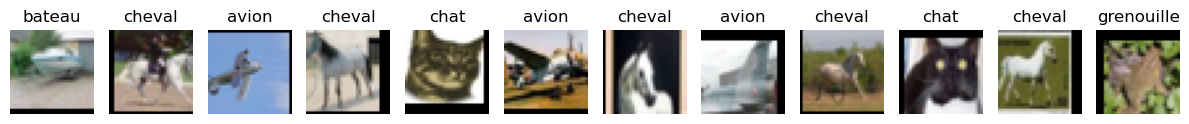

Echantillon sauvegardés sans 'samples.png'


In [ ]:
# Visualisation
def visualize_samples(loader, num_samples=12):
  dataiter = iter(loader)
  images, labels = next(dataiter)
  fig, axes = plt.subplots(1,12,figsize=(12,6))
  for i, ax in enumerate(axes.flat):
      img = images[i].numpy().transpose((1,2,0)) #format image numpy
      img = img * 0.5 +0.5 #dénormaliser
      ax.imshow(img)
      ax.set_title(classes[labels[i]])
      ax.axis('off')
  plt.tight_layout()
  plt.show()

visualize_samples(train_loader)

2. Construction du modèle CNN

Nous allons à présent constuire notre modèle CNN, en appliquant plusieurs couches différentes dans 3 blocs convolutionnels, et enfin une couche Fully Connected.

In [ ]:
# Modèle CNN

class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()

        # Bloc convolutionnel 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        # Bloc convolutionnel 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        # Bloc convolutionnel 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        # Couches fully connected
        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)  # Aplatir
        x = self.fc(x)
        return x

# Initialiser le modèle
model = ConvNet(num_classes=10).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Afficher l'architecture
print(model)
print(f"\nNombre de paramètres: {sum(p.numel() for p in model.parameters()):,}")




=== 2. Modèle CNN ===
ConvNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mod

3. Entraînement du modèle

Dans cette partie, nous allons entraîner le modèle CNN défini plus haut sur la base CIFAR-10.

In [1]:

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Entraînement', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': f'{loss.item():.3f}', 'acc': f'{100.*correct/total:.2f}%'})

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation', leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Historique de l'entraînement
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_acc = 0.0

for epoch in range(EPOCHS):
    print(f"\nÉpoque {epoch+1}/{EPOCHS}")

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Scheduler
    scheduler.step(val_loss)

    # Sauvegarder le meilleur modèle
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Meilleur modèle sauvegardé (val_acc: {val_acc:.2f}%)")

# Chargement du meilleur modèle
model.load_state_dict(torch.load('best_model.pth'))
print(f"\nMeilleure précision de validation: {best_val_acc:.2f}%")

NameError: name 'EPOCHS' is not defined

4. Visualisation

Visualisons les résultats de l'entraînement.

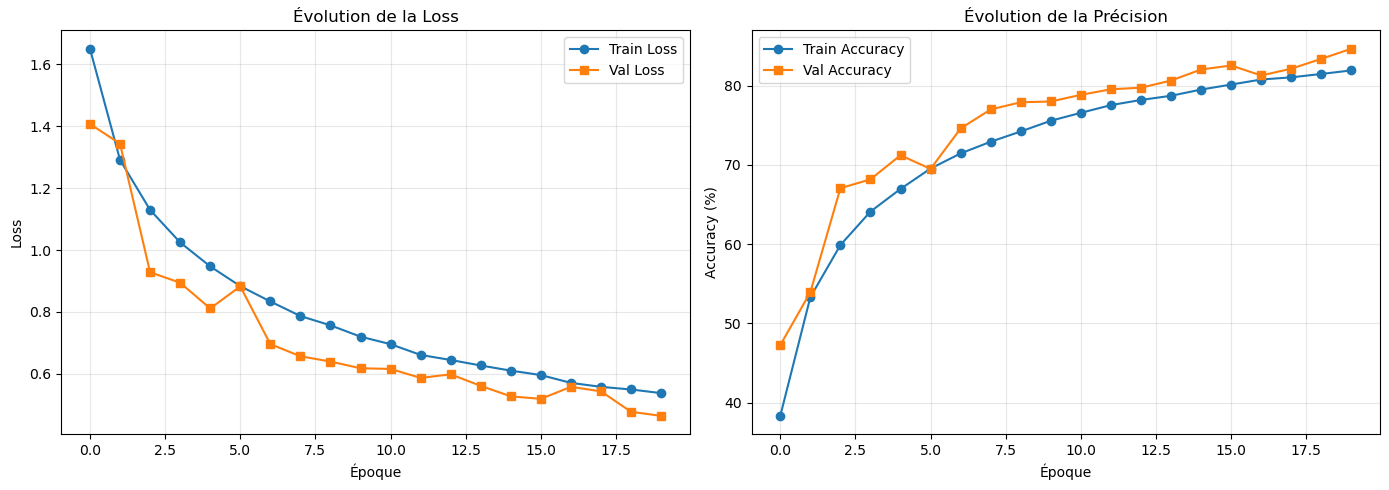

Historique sauvegardé dans 'training_history.png'


In [ ]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Époque')
ax1.set_ylabel('Loss')
ax1.set_title('Évolution de la Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(history['train_acc'], label='Train Accuracy', marker='o')
ax2.plot(history['val_acc'], label='Val Accuracy', marker='s')
ax2.set_xlabel('Époque')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Évolution de la Précision')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


On constate ici que le modèle fonctionne bien : il n'apprend pas simplement par coeur les pattern, mais fonctionne aussi sur des images qu'il n'a jamais vues. Il n'y a visiblement pas d'overfitting, la loss décroit avec le nombre d'époques, et la précision augmente.

5. Evaluation avec les données test

Nous allons à présent appliquer le modèle sur les données test.

In [ ]:
def evaluate_model(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Test'):
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_labels), np.array(all_preds)

y_true, y_pred = evaluate_model(model, test_loader, DEVICE)

Test: 100%|██████████| 157/157 [00:12<00:00, 13.04it/s]


6. Métriques de performance

Afin de visualiser plus clairement les résultats, nous allons définir des métriques de performances.

In [ ]:
# Précision globale
test_accuracy = accuracy_score(y_true, y_pred)
print(f"\n Précision globale: {test_accuracy*100:.2f}%\n")

# Rapport de classification
print("Rapport de classification:\n")
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

# Métriques par classe
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)

print("\nMétriques par classe:")
print(f"{'Classe':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 60)
for i, class_name in enumerate(classes):
    print(f"{class_name:<12} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")



 Précision globale: 85.28%

Rapport de classification:

              precision    recall  f1-score   support

       avion     0.8665    0.8700    0.8683      1000
        auto     0.9373    0.9270    0.9321      1000
      oiseau     0.7750    0.8230    0.7983      1000
        chat     0.7662    0.6490    0.7028      1000
        cerf     0.8137    0.8690    0.8404      1000
       chien     0.7638    0.8050    0.7838      1000
  grenouille     0.8870    0.8790    0.8830      1000
      cheval     0.9279    0.8500    0.8873      1000
      bateau     0.8911    0.9330    0.9116      1000
      camion     0.9031    0.9230    0.9130      1000

    accuracy                         0.8528     10000
   macro avg     0.8532    0.8528    0.8520     10000
weighted avg     0.8532    0.8528    0.8520     10000


Métriques par classe:
Classe       Precision    Recall       F1-Score     Support   
------------------------------------------------------------
avion        0.8665       0.8700     

7. Matrice de confusion

Pour une visualisation plus graphique des résultats, nous pouvons utiliser une matrice de confusion.

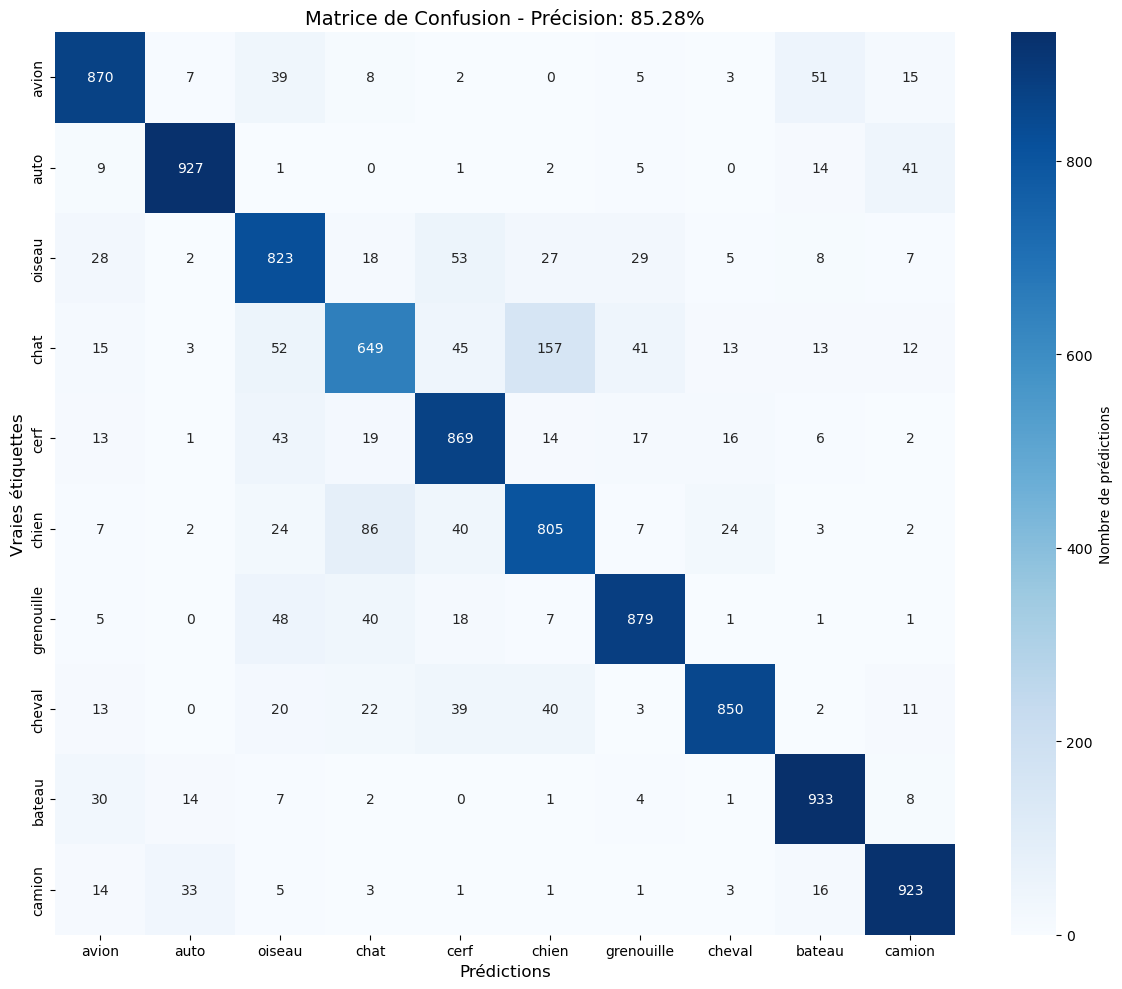

In [ ]:
cm = confusion_matrix(y_true, y_pred)

# Visualisation
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Nombre de prédictions'})
plt.xlabel('Prédictions', fontsize=12)
plt.ylabel('Vraies étiquettes', fontsize=12)
plt.title(f'Matrice de Confusion - Précision: {test_accuracy*100:.2f}%', fontsize=14)
plt.tight_layout()
plt.show()


8. Analyse des erreurs

Analysons maintenant les erreurs.


Nombre d'erreurs: 1472 / 10000 (14.72%)


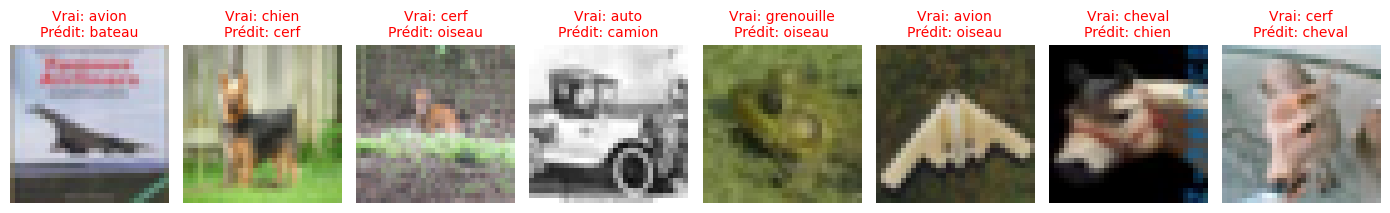

In [ ]:
errors = y_true != y_pred
error_indices = np.where(errors)[0]

print(f"\nNombre d'erreurs: {len(error_indices)} / {len(y_true)} ({len(error_indices)/len(y_true)*100:.2f}%)")

# Visualiser certaines erreurs
if len(error_indices) > 0:
    test_dataset_list = list(test_loader.dataset)

    fig, axes = plt.subplots(1, 8, figsize=(14, 7))
    for i, ax in enumerate(axes.flat):
        if i < min(8, len(error_indices)):
            idx = error_indices[i]
            img, true_label = test_dataset_list[idx]
            pred_label = y_pred[idx]

            img = img.numpy().transpose((1, 2, 0))
            img = img * 0.5 + 0.5  # Dénormalisation

            ax.imshow(img)
            ax.set_title(f'Vrai: {classes[true_label]}\nPrédit: {classes[pred_label]}',
                        color='red', fontsize=10)
            ax.axis('off')

    plt.tight_layout()
    plt.show()


Conclusion

In [ ]:
print("Conclusion")
print()
print(f"Dataset: CIFAR-10 (60,000 images, 10 classes)")
print(f"Architecture: CNN avec 3 blocs convolutionnels")
print(f"Paramètres: {sum(p.numel() for p in model.parameters()):,}")
print(f"Époques d'entraînement: {EPOCHS}")
print(f"Meilleure précision validation: {best_val_acc:.2f}%")
print(f"Précision test: {test_accuracy*100:.2f}%")
print(f"Device utilisé: {DEVICE}")
print()

Conclusion

Dataset: CIFAR-10 (60,000 images, 10 classes)
Architecture: CNN avec 3 blocs convolutionnels
Paramètres: 1,342,122
Époques d'entraînement: 20
Meilleure précision validation: 84.66%
Précision test: 85.28%
Device utilisé: cpu



### II. Approfondissement de la vision par CNN : MTCNN, FaceNet, SVM

La seconde partie du notebook consiste en des applications d'architectures CNN. Dans un premier temps, nous allons utiliser MTCNN pour la détection de visages, puis essayer de reconnaître des visages de célébrité à l'aide de FaceNet puis SVM.

In [ ]:
#!pip install tensorflow mtcnn keras-facenet scikit-learn opencv-python matplotlib

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 55.2 MB/s eta 0:00:00
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10367 sha256=c911a359702384e4ff700f6515a584cd776c6c59459516f1e62a9533add255c3
  Stored in directory: /root/.cache/pip/wheels/05/b0/f5/19ac49fedc10b1df3ee56b096edbcfa39d45794fccc6bcdbbf
Successfully built keras-facenet


In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# MTCNN et FaceNet
from mtcnn import MTCNN
from keras_facenet import FaceNet

# Machine Learning
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Configuration matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

2026-02-01 17:49:22.365871: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1. MTCNN

MTCNN est un réseau de neurones qui détecte les visages et leurs points de repère.

In [12]:
detector = MTCNN()

def detect(image_path):
    """
    Détecte et affiche les visages dans une image
    """
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    faces = detector.detect_faces(image_rgb)

    print(f"{len(faces)} visage(s) détecté(s)")

    for i, face in enumerate(faces, 1):
        x, y, w, h = face['box']
        confidence = face['confidence']

        # Rectangle
        cv2.rectangle(image_rgb, (x, y), (x+w, y+h), (0, 255, 0), 3)

        # Points de repère
        for point in face['keypoints'].values():
            cv2.circle(image_rgb, point, 4, (255, 0, 0), -1)

        # Texte
        cv2.putText(image_rgb, f"Face {i} ({confidence:.2f})",
                   (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        print(f"  Face {i}: confiance={confidence:.2f}, position={face['box']}")

    plt.figure(figsize=(14, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f'Détection MTCNN - {len(faces)} visage(s)', fontsize=16)
    plt.show()

    return faces, image_rgb

1 visage(s) détecté(s)
  Face 1: confiance=0.99, position=[555, 434, 604, 814]


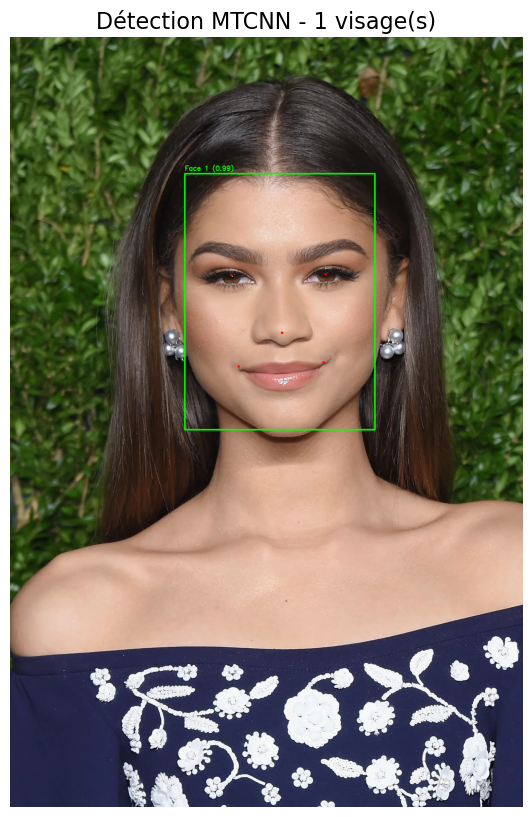

In [13]:
# Test
test_image = './zendaya_1.jpg'

if os.path.exists(test_image):
    faces, image = detect(test_image)
else:
    print(f"Image non trouvée: {test_image}")
    print("Modifiez le chemin dans la cellule ci-dessus")

2. FaceNet

FaceNet transforme chaque visage en un vecteur de 512 dimensions.

In [14]:
facenet = FaceNet()

def extract(image, face_data, size=(160, 160)):
    """
    Extrait un visage depuis une image
    """
    x, y, w, h = face_data['box']
    x, y = abs(x), abs(y)

    face = image[y:y+h, x:x+w]
    face_resized = cv2.resize(face, size)

    return face_resized


In [15]:
def get_embedding(face_pixels):
    face_pixels = face_pixels.astype('float32')

    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / (std + 1e-8)

    samples = np.expand_dims(face_pixels, axis=0)
    embedding = facenet.embeddings(samples)[0]

    embedding = embedding / np.linalg.norm(embedding)

    return embedding


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
   Shape: (512,)
   Type: float32
   Premières valeurs: [ 0.01040817  0.01323743 -0.08136161  0.03703693 -0.00583531]
   Norme L2: 1.0000


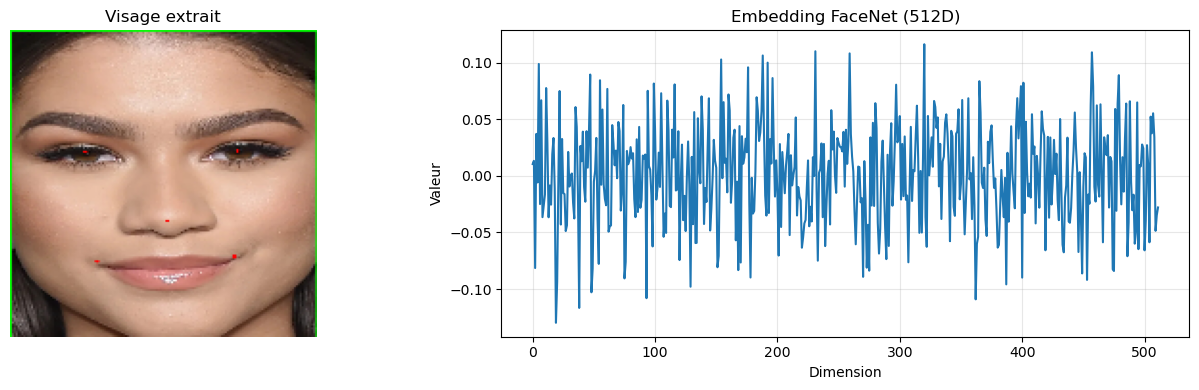

In [16]:
# Test
if 'faces' in globals() and len(faces) > 0:
    face_array = extract(image, faces[0])
    embedding = get_embedding(face_array)

    print(f"   Shape: {embedding.shape}")
    print(f"   Type: {embedding.dtype}")
    print(f"   Premières valeurs: {embedding[:5]}")
    print(f"   Norme L2: {np.linalg.norm(embedding):.4f}")

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(face_array)
    plt.title('Visage extrait')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.plot(embedding)
    plt.title('Embedding FaceNet (512D)')
    plt.xlabel('Dimension')
    plt.ylabel('Valeur')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Exécutez d'abord la cellule de détection de visages")

In [ ]:
from sklearn.model_selection import train_test_split

def collect(dataset_path):
    image_paths = []
    labels = []

    for person in os.listdir(dataset_path):
        person_dir = os.path.join(dataset_path, person)
        if not os.path.isdir(person_dir):
            continue

        for img in os.listdir(person_dir):
            if img.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(person_dir, img))
                labels.append(person)

    return np.array(image_paths), np.array(labels)

# Define dataset_path
dataset_path = './complete_dataset'

# Collecte
image_paths, labels = collect(dataset_path)

print(f"Total images: {len(image_paths)}")
print(f"Classes: {np.unique(labels)}")

# Split avant embeddings
train_paths, test_paths, y_train_labels, y_test_labels = train_test_split(
    image_paths,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

print(f"Train images: {len(train_paths)}")
print(f"Test images: {len(test_paths)}")

Total images: 21
Classes: ['Tom Holland' 'Zendaya']
Train images: 16
Test images: 5


In [29]:
import gc
import numpy as np

def create_embeddings(image_paths, labels, min_confidence=0.8):
    embeddings = []
    valid_labels = []

    for path, label in zip(image_paths, labels):
        image = cv2.imread(path)
        if image is None:
            continue

        h, w, _ = image.shape
        if h < 80 or w < 80:
            del image
            continue

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        try:
            faces = detector.detect_faces(image_rgb)
        except Exception:
            del image, image_rgb
            continue

        if not faces:
            del image, image_rgb
            continue

        face = max(faces, key=lambda x: x['confidence'])
        if face['confidence'] < min_confidence:
            del image, image_rgb, faces
            continue

        x, y, width, height = face['box']
        if width <= 0 or height <= 0:
            del image, image_rgb, faces
            continue

        try:
            face_array = extract(image_rgb, face)
            embedding = get_embedding(face_array)
        except Exception:
            del image, image_rgb, faces
            continue

        embeddings.append(embedding.astype(np.float32))
        valid_labels.append(label)

        del image, image_rgb, face_array, embedding, faces
        gc.collect()

    return np.asarray(embeddings, dtype=np.float32), np.asarray(valid_labels)



In [30]:
print("Création des embeddings train")
X_train, y_train = create_embeddings(train_paths, y_train_labels)

print("Création des embeddings test")
X_test, y_test = create_embeddings(test_paths, y_test_labels)

print(f"Train embeddings: {X_train.shape}")
print(f"Test embeddings: {X_test.shape}")

Création des embeddings train
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Création des embeddings test
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Train embeddings: (16, 512)
Test embeddings: (5, 512)


3. Modèle SVM

In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encodage labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# Standardisation pour le SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
svm_model = SVC(kernel='linear', probability=True, C=1.0)
svm_model.fit(X_train_scaled, y_train_enc)

print("Entraînement terminé")

# Évaluation
y_train_pred = svm_model.predict(X_train_scaled)
y_test_pred = svm_model.predict(X_test_scaled)

print(f"Train accuracy: {accuracy_score(y_train_enc, y_train_pred)*100:.2f}%")
print(f"Test accuracy: {accuracy_score(y_test_enc, y_test_pred)*100:.2f}%")

print("\n Rapport de classification (test):")
print(classification_report(
    y_test_enc,
    y_test_pred,
    target_names=label_encoder.classes_,
    zero_division=0
))

Entraînement terminé
Train accuracy: 56.25%
Test accuracy: 50.00%

 Rapport de classification (test):
              precision    recall  f1-score   support

 Tom Holland       0.00      0.00      0.00         2
     Zendaya       0.50      1.00      0.67         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33         4
weighted avg       0.25      0.50      0.33         4



In [17]:
embedding = get_embedding(face_array)
embedding = scaler.transform([embedding])
probabilities = svm_model.predict_proba(embedding)[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


In [31]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm_cv = SVC(kernel='linear', probability=True, C=1.0)
scores = cross_val_score(
    svm_cv,
    X_train_scaled,
    y_train_enc,
    cv=cv
)

print(f"CV accuracy: {scores.mean()*100:.2f}% ± {scores.std()*100:.2f}%")

CV accuracy: 56.67% ± 13.33%
